<ipython-input-74-0a19ed7baf33>:70: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('GJ3512.png', bbox='tight')


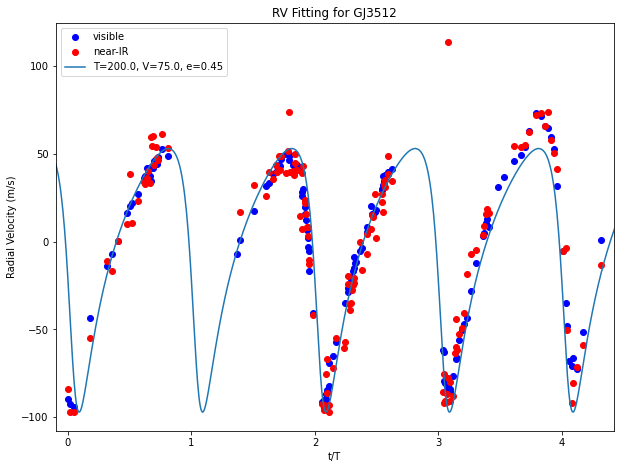

In [74]:
# This program finds a fit for a general RV dataset from the NASA Exoplanet Archive
# Author: Alex Correia
# Date: 7/5/21

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def rv(T, V, e, w, C, t0):
    '''
    Using the parameters in the argument, make a model of radial velocity vs time. Compare with observational data to
    estimate parameters for a dataset.
    
    Estimated parameters:
    T = period of curve (days); estimated period of oscillation for stellar wobbling.
    V = amplitude of curve (m/s); estimated max radial velocity of the star.
    e = eccentricity of planetary orbit.
    w = angle (radians) between space/orbital plane intersection and planetary aphelion.
    C = constant velocity (m/s) of system COM along observation axis.
    t0 = constant scaled time for start of period
    
    Computed parameters:
    t = time during orbit. Scaled with period t/T in loop
    theta = angle on orbital plane between aphelion and current planet position.
    vz = radial velocity of star along axis of observation
    '''
    pi, psi = np.pi, np.linspace(-10*np.pi, 10*np.pi, 1000)
    t = (psi + e*np.sin(psi))/(2*pi) + t0                  # Kepler eqn w/ horizontal shift t0
    theta = np.arccos((e+np.cos(psi))/(1+(e*np.cos(psi)))) # relate theta to psi
    for i in range(-10, 10):
        theta = np.concatenate((theta[psi<=i*pi], 2*pi-theta[psi>i*pi]))    # map theta to [0, 2pi]
    vz = -V*(np.cos(w + theta) - e*np.cos(w)) + C
    plt.plot(t, vz, label="T=%.1f, V=%.1f, e=%.2f"%(T, V, e))                                              
    plt.xlabel("t/T")
    plt.ylabel("Radial Velocity (m/s)")
    plt.title("RV Fitting for GJ3512")
    plt.legend()

# read in and plot data from a generic RV dataset (stored as fixed-width files)
df1 = pd.read_fwf('GJ3512-vis.dat', names=["Date", "RV", "Error"])
df2 = pd.read_fwf('GJ3512-nir.dat', names=["Date", "RV", "Error"])
times1 = df1['Date'].tolist()    # Julian dates of observation
vels1 = df1['RV'].tolist()       # radial velocities
err1 = df1['Error'].tolist()     # errorbars
times2 = df2['Date'].tolist()    # Julian dates of observation
vels2 = df2['RV'].tolist()       # radial velocities
err2 = df2['Error'].tolist()     # errorbars


### make parameter predictions here ###
p = [200, 75, 0.45, 4, 0, 0.54]
T, V, e, w, C, t0 = range(6)

# shift Julian dates such that times[0] = 0
start = times1[0]
for i in range(len(times1)):
    times1[i] = (times1[i] - start)/p[T]
for i in range(len(times2)):
    times2[i] = (times2[i] - start)/p[T]

# plot v vs t
plt.figure(figsize=(10, 7.5))
plt.plot(times1, vels1, 'bo', label='visible')
plt.plot(times2, vels2, 'ro', label='near-IR')
plt.xlim(-0.1, times1[-1]+0.1)

# plot the curve using estimates for (T, V, e, w, C, t0)
rv(p[T], p[V], p[e], p[w], p[C], p[t0])

plt.savefig('GJ3512.png', bbox='tight')

In [66]:
def mass_lim(e, T, M, V):                                   #[T] = days, [M] = M_sun, [V] = m/s
    '''
    After finding a good fit for a given dataset, use the parameters to find an estimate for the mass of the planet.
    e, T, and V have the same meaning as above.
    M is the mass of the host star in solar masses.
    The function returns a lower mass limit in Earth masses.
    '''
    return 11*np.sqrt(1-e**2)*((T/365.25)*M**2)**(1/3)*V

M = 0.127

earth_mass = mass_lim(p[e], p[T], M, p[V])                  # Earth masses
jupiter_mass = earth_mass / 318                             # 1 Jupiter mass ~ 318 Earth masses

print("Min Earth mass = %f Mᴇ, Min Jupiter mass = %f Mᴊ"%(earth_mass, jupiter_mass))

Min Earth mass = 153.046609 Mᴇ, Min Jupiter mass = 0.481279 Mᴊ
